# C-M-009: Machine Learning Lab II ’21-22
Lab. 2 (Given December 11, 2021; Due December 13, 2021)


#### Part a

## Let's start with a **Simple Auto Encoder.**

In [32]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np

In [33]:
encoding_dim = 32 
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)

In [34]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [35]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [36]:
# Loading the MNIST datasets
(x_train, _), (x_test, _) = mnist.load_data()

In [37]:
# Normalize the dataset
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [38]:
# Training the autoencoder for 50 epochs
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2762 - val_loss: 0.1890
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1706 - val_loss: 0.1535
Epoch 3/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1442 - val_loss: 0.1337
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1286 - val_loss: 0.1211
Epoch 5/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1181 - val_loss: 0.1123
Epoch 6/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1106 - val_loss: 0.1061
Epoch 7/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1053 - val_loss: 0.1018
Epoch 8/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1015 - val_loss: 0.0987
Epoch 9/50
235/235 [==============================] - 3s 12ms/step - loss: 0.0990 - val_loss: 0.0967
Epoch 10/50
235/235 [==============================] - 3s 12ms/step - loss: 0.0972 - val_lo

In [39]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

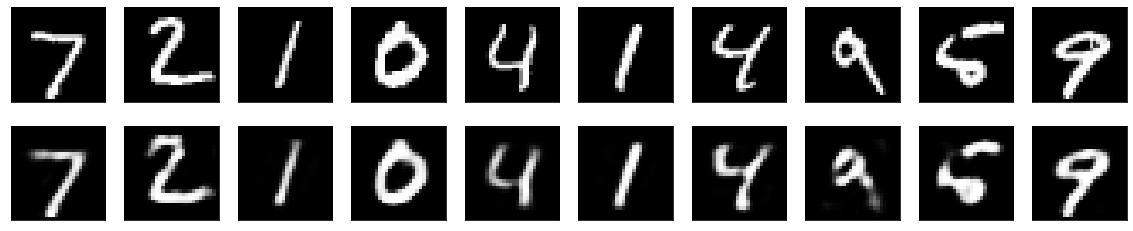

In [40]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Now let's make the **Variational autoencoder (VAE)**

In [41]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2


Mapping inputs to our latent distribution parameters.

In [42]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

Use these parameters to sample new similar points from the latent space.


In [43]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Map these sampled latent points back to reconstructed inputs.

In [44]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [45]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

We train our VAE on MNIST digits.

In [46]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 9s 4ms/step - loss: 186.3815 - val_loss: 168.0378
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 165.5816 - val_loss: 163.7552
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 162.2719 - val_loss: 161.2569
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 160.2466 - val_loss: 159.7625
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 158.7347 - val_loss: 158.4921
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 157.4428 - val_loss: 157.2622
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 156.3347 - val_loss: 155.9947
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 155.4255 - val_loss: 155.3987
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 154.6239 - val_loss: 154.4130
Epoch 10/100
1875/1875 [=============

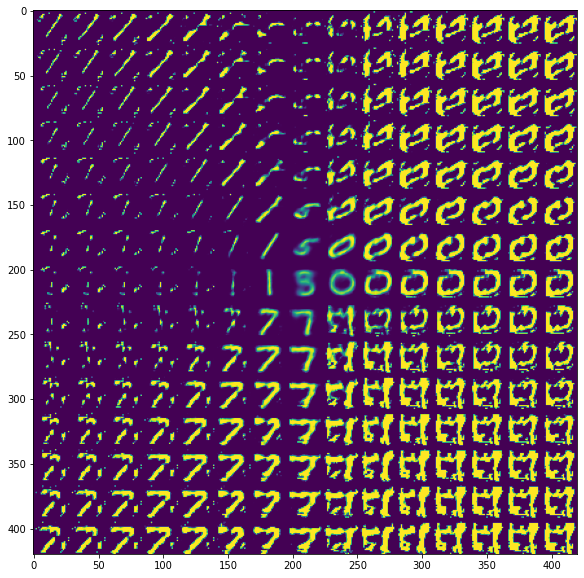

In [14]:
# Display a 2D manifold of the digits
from matplotlib import pyplot as plt
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

We can use the summary function to get more idea about the fit

In [50]:
vae.summary()


Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          50500       ['input_6[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          51152       ['encoder[0][2]']                
                                                                                            

Try finding mean and log of the variance. We will have two latent variables both for mean and log of variance.

In [54]:
vae.get_layer("encoder").get_weights()[0]


array([[-5.3907417e-02,  4.9488850e-02, -7.1783125e-02, ...,
        -5.5038705e-02, -4.0638536e-02, -6.7122281e-05],
       [ 3.8326658e-02,  6.3901149e-02,  3.4858145e-02, ...,
        -5.4848209e-02,  8.2396716e-04, -4.0981814e-02],
       [-2.3510054e-02, -8.3553411e-02,  7.9244085e-02, ...,
         3.0373722e-02, -2.3389984e-02,  1.0454074e-02],
       ...,
       [ 3.7111685e-02,  6.5406851e-02,  3.5421103e-02, ...,
        -1.6299933e-03,  8.1739835e-02, -6.8266176e-02],
       [ 3.9248578e-02,  3.9914116e-02,  5.8632679e-02, ...,
         6.8648256e-02,  1.9096017e-02, -6.1539263e-03],
       [-5.7743758e-02, -1.3319038e-02, -8.2374252e-02, ...,
         6.6363439e-03,  7.8016825e-02,  3.6031336e-02]], dtype=float32)

In [55]:
vae.get_layer("encoder").get_weights()[1]

array([ 2.933018  , -0.02437224,  1.5781105 , -1.3015045 , -0.02601997,
       -0.02475055, -0.01984213,  1.8938636 ,  3.193101  ,  0.85487056,
       -0.02512139,  2.1651711 , -0.02792674,  1.9081775 , -0.02170549,
        2.0902822 , -0.02288986, -0.03195587, -0.02841671, -0.01650525,
       -1.5694764 , -0.01911079, -0.02689581,  0.70716137,  1.1489841 ,
       -0.01961759, -0.04356992,  2.8033295 , -0.02523091,  2.5162296 ,
       -0.06023278,  1.4501058 ,  3.5390444 , -0.01987918, -0.0240124 ,
       -0.01769041,  0.46141985,  0.41520143, -0.02826693, -0.04436166,
        2.1287448 , -0.02325533,  1.22954   ,  1.3425235 ,  0.08703209,
        2.6056802 , -0.02039171,  2.461498  ,  1.7076136 ,  1.7542967 ,
       -0.02186193,  0.8868541 ,  2.0123374 ,  1.7980869 ,  1.8050478 ,
        1.5321878 , -0.02097308, -0.02370415,  1.0596166 , -0.04310621,
       -0.03077562, -0.025195  ,  2.2943652 , -0.91339946], dtype=float32)

In [56]:
vae.get_layer("encoder").get_weights()[2]

array([[ 3.68623249e-02,  3.32076959e-02],
       [-8.06089342e-02,  3.05837747e-02],
       [ 1.40179038e-01,  7.78086632e-02],
       [ 1.26047281e-03, -2.09380649e-02],
       [-1.09329313e-01,  5.77845126e-02],
       [-1.48406819e-01, -1.76123634e-01],
       [-2.67701656e-01, -1.38156533e-01],
       [ 6.67153522e-02,  1.83199972e-01],
       [ 5.29821813e-02, -3.89515162e-02],
       [ 1.74566492e-01, -6.29652617e-03],
       [-5.86491860e-02, -2.60638744e-01],
       [-3.54666002e-02,  8.68269578e-02],
       [-1.05738834e-01,  9.98829305e-02],
       [-1.39992693e-02,  2.93964475e-01],
       [-2.12465286e-01, -2.01614335e-01],
       [-1.15304030e-02,  4.52267416e-02],
       [ 9.44991484e-02, -2.38076478e-01],
       [-1.95256416e-02,  3.52810211e-02],
       [-4.43368964e-02,  3.77528556e-02],
       [-7.42561696e-03, -9.40910913e-03],
       [-1.00364909e-03, -1.85101014e-02],
       [-2.59929210e-01,  2.08899051e-01],
       [-1.28406852e-01, -2.61190534e-03],
       [ 1.

In [57]:
vae.get_layer("encoder").get_weights()[3]

array([-0.05883577, -0.21751447], dtype=float32)

In [69]:
mean = vae.get_layer("encoder").get_weights()[3]

In [58]:
vae.get_layer("encoder").get_weights()[4]

array([[ 0.0624605 ,  0.04487477],
       [ 0.21467875,  0.0032395 ],
       [ 0.05464019,  0.05426055],
       [-0.01841285, -0.02260039],
       [-0.05080549,  0.24167502],
       [ 0.06754342, -0.17629954],
       [ 0.09566799,  0.08536748],
       [-0.00246955,  0.09778415],
       [ 0.05228821,  0.03523397],
       [ 0.06888779,  0.0294216 ],
       [ 0.09903638,  0.29119948],
       [ 0.00121292,  0.06697104],
       [-0.01616875, -0.2821268 ],
       [ 0.0023667 ,  0.11780497],
       [ 0.09454785, -0.07453123],
       [ 0.01290677,  0.01723673],
       [ 0.17597872,  0.27635682],
       [ 0.24069665,  0.14158581],
       [ 0.06607174, -0.19174254],
       [-0.22412421, -0.01421758],
       [ 0.00052098, -0.05175895],
       [ 0.20285518, -0.14664325],
       [-0.02155622, -0.1074597 ],
       [-0.01848524,  0.00293277],
       [ 0.04152191,  0.02793993],
       [ 0.22748558, -0.2112745 ],
       [ 0.08286534,  0.18601912],
       [ 0.03445202,  0.04025359],
       [ 0.17697962,

In [59]:
vae.get_layer("encoder").get_weights()[5]

array([-1.7993336, -1.841611 ], dtype=float32)

In [63]:
logv = vae.get_layer("encoder").get_weights()[5]

In [66]:
import math

sd = []
for i in range(len(logv)):
  sd1 = math.sqrt(math.exp(i))
  sd.append(sd1)

print(sd)

[1.0, 1.6487212707001282]


In [71]:
import matplotlib.pyplot as plt

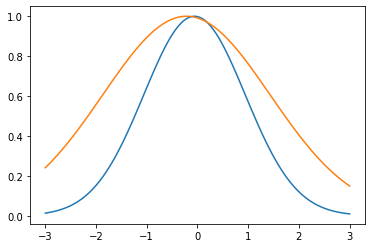

In [72]:
x_values = np.linspace(-3, 3, 120)
for i in range(2):
  mu = mean[i]
  sig = sd[i]
  g = np.exp(-np.power(x_values - mu, 2.) / (2 * np.power(sig, 2.)))
  plt.plot(x_values, g)


### Part b

#### Each latent variable is controlling:
1. The represent the **mean** and the **standard** **deviation** of the graph.
2. The decodability of the decoder.
3. The encodability of the encoder. 
4. The **ability of the hidden layers** to produce an output seemingly close to the input.
5. The flexibility of the hidden layer neurons in predicting different **types** of outputs.